In [3]:
import csv
import numpy as np
import scipy
import networkx as nx
import math
import sys
import os
import subprocess
import scipy.stats
import scipy.optimize
import operator
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from scipy.sparse import csr_matrix

sys.path.append("../Python_code") # go to parent dir
from canvas_vis import * 
from analytics_combined import *
from generate_proj_to_remove import *
from project_data_analysis import *
from user_embedding import *
from segmentation import *
from evaluation import *
import pickle

In [44]:
#Parameters

#Area of the canvas considered (0-1002,0-1002 is the full canvas)
min_x = 100
max_x = 150
#max_x = 1002
min_y = 100
#max_y = 1002
max_y = 150

#distance threshold in update graphs
#updates within dist_threshold positions from each other
#that co-exist at any point in time will be connected
dist_threshold = 1

#Multithreading
num_threads = 3

#User signed embedding parameters
ndim=120
threshold=5
total_samples=300
n_negatives=5
n_iterations=10

In [4]:
#Reading ground truth data

t = time.time()

projects_to_remove = get_list_of_removed_proj(output_filename = "../data/proj_to_remove.txt")

input_file= "../data/sorted_tile_placements_proj.csv"
js_filename = "../data/atlas_complete.json"

names, descriptions = read_picture_names_and_descriptions(js_filename)

print("time = ", time.time()-t, " seconds")

time =  408.4091725349426  seconds


In [45]:
G_ups, ups = create_graph(input_file, projects_to_remove, dist_threshold, min_x, max_x, min_y, max_y)

In [5]:
user_index_sign, emb_sign = embed_users_sign(G_ups, ups, ndim, threshold, total_samples, n_negatives, n_iterations, True)
#user_index_act, emb_act = embed_users_act(G_ups, ups, ndim, threshold, total_samples, n_negatives, n_iterations)

python2.7 ../../signet/signet.py -l signet_id.txt -i signet.txt -o signet -d 120 -t 5 -s 300
balanced:
+++  0.5976787139066786  rand =  0.2938515707880298
+--  0.17136926107885272  rand =  0.22406081377688286
unbalanced:
++-  0.20882533484044638  rand =  0.4444343216282286
---  0.022126690174022322  rand =  0.03765329380685877
avg pos =  0.8186107516422889 , n =  16547688
avg neg =  1.3860524484119492 , n =  8342489


In [6]:
pfile = open('sign_emb.pkl', 'wb')
pickle.dump([user_index_sign, emb_sign], pfile)
pfile.close()

In [41]:
import subprocess
def generate_user_unsigned_net(G, user_index, output_file_name):
    '''
    '''
    with open(output_file_name+".txt", 'w') as file_out:
        writer = csv.writer(file_out, delimiter = "\t")

        for e in G.edges():
            w = G.edges[e]['weight']
            u = int(e[0])
            v = int(e[1])
            writer.writerow([u+1, v+1, w])

    with open(output_file_name+"_id.txt", 'w') as file_out:
        writer = csv.writer(file_out, delimiter = "\t")
        for ID in user_index:
            writer.writerow([ID])

def act_embedding(G, user_index, output_file_name,
    ndim=2, threshold=5, total_samples=100, n_negatives=5,
    n_iterations=10):
    '''
    '''
    generate_user_unsigned_net(G, user_index, output_file_name)
    print("python "+signet_path+" -l actnet_id.txt -i actnet.txt -o "+output_file_name+ " -d "+str(ndim)+" -t "+str(threshold)+" -s "+str(total_samples))
    
    out = subprocess.check_output("python2.7 "+signet_path+" -l actnet_id.txt -i actnet.txt -o "+output_file_name+ " -d "+str(ndim)+" -t "+str(threshold)+" -s "+str(total_samples)
, shell=True)
    #os.system("python2.7 "+signet_path+" -l actnet_id.txt -i actnet.txt -o "+output_file_name+ " -d "+str(ndim)+" -t "+str(threshold)+" -s "+str(total_samples))
    print(out)
    
def embed_users_act(G, ups, ndim=40, threshold=5, total_samples=100, n_negatives=5, n_iterations=10):
    '''
    '''
    G_act, user_index = compute_user_activity_graph(G, ups, color=True)

    #act_embedding(G_act, user_index, "actnet", ndim, threshold, total_samples, n_negatives,  n_iterations)


    #emb = read_embedding("actnet", user_index, ndim)

    node2vec = Node2Vec(G_act, dimensions=ndim, walk_length=80, num_walks=10, workers=32, temp_folder='./tmp/')
    model = node2vec.fit(window=10, min_count=1, batch_words=100, negative=n_negatives)
    emb = np.zeros((G_act.number_of_nodes(), ndim))

    for v in G_act.nodes():
        emb[int(v)] = model.wv[str(v)]

    return user_index, emb


In [42]:
user_index_act, emb_act = embed_users_act(G_ups, ups, ndim, threshold, 10, n_negatives, n_iterations)

Computing transition probabilities:  11%|█         | 97586/904141 [6:12:50<32:52:59,  6.81it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Computing transition probabilities:  12%|█▏        | 106391/904141 [6:39:26<49:11:22,  4.50it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Computing transition probabilities:  13%|█▎        | 115027/904141 [7:04:57<49:46:56,  4.40it/s] IOPub message rate exceeded.
The notebook server will tempo

Computing transition probabilities:  39%|███▉      | 351317/904141 [13:10:13<27:25:10,  5.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Computing transition probabilities:  41%|████      | 372519/904141 [13:25:47<5:01:08, 29.42it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Computing transition probabilities:  44%|████▍     | 395590/904141 [13:40:52<4:37:39, 30.53it/s] IOPub message rate exceeded.
The notebook server will tempo

KeyboardInterrupt: 

In [75]:
len(user_index_act)

969

In [ ]:
python ../../signet/signet.py -l actnet_id.txt -i actnet.txt -o actnet -d 120 -t 5 -s 10

In [30]:
pfile = open('act_emb.pkl', 'wb')
pickle.dump([user_index_act, emb_act], pfile)
pfile.close()

In [31]:
'TDCIMp5uLNNbOS8BG+e3sBRJPZU=' in user_index_act

False

In [35]:
G_act, user_index = compute_user_activity_graph(G_ups, ups, gcc=False, final=False)

In [38]:
nx.is_connected(G_act)

False

In [36]:
G_act.number_of_nodes()

1139526

In [37]:
G_act.number_of_edges()

40106200

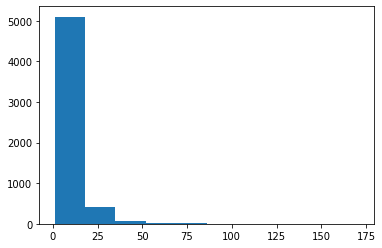

In [7]:
degrees = [G_act.degree(n) for n in G_act.nodes()]
plt.hist(degrees)
plt.show()

In [12]:
n = 0
for up in ups:
    if up[6] == 1:
        n = n + 1
        
print(n)

6491


In [44]:
G_act.degree(2458)

379

In [53]:
for v in user_index:
    if user_index[v] == 3527:
        print(v)

5CNDNkwtGH7Jiryb5aoZF/bM9YA=


In [51]:
for up in ups:
    if up[1] == 'F7XawLj6tGYEr095+/Dbjrrweos=':
        print(up)

[1491008986000, 'F7XawLj6tGYEr095+/Dbjrrweos=', 820, 403, 3, '242', 0, 0]


In [52]:
list(G_act.neighbors(3528))

[3527]

In [54]:
for up in ups:
    if up[1] == '5CNDNkwtGH7Jiryb5aoZF/bM9YA=':
        print(up)

[1491008981000, '5CNDNkwtGH7Jiryb5aoZF/bM9YA=', 820, 402, 3, '242', 0, 0]


In [55]:
list(G_act.neighbors(3527))

[3528, 984100, 1117426]

In [56]:
G_act.number_of_nodes()

1102748

In [74]:
np.count_nonzero(np.array(degrees)==10) / G_act.number_of_nodes()

0.026560918723044613

In [60]:
np.array(degrees)>0

array([ True,  True,  True, ...,  True,  True,  True])

In [63]:
G_act.number_of_edges()

35557701

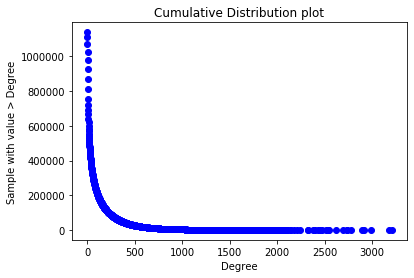

In [39]:
import collections

degree_sequence = sorted([d for n, d in G_act.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
cs = np.cumsum(cnt)
plt.plot(deg, cs, 'bo')
plt.title("Cumulative Distribution plot")
plt.ylabel("Sample with value > Degree")
plt.xlabel("Degree")
plt.show()

In [67]:
degrees

[594,
 190,
 167,
 98,
 161,
 12,
 250,
 520,
 1038,
 12,
 652,
 82,
 45,
 238,
 210,
 69,
 310,
 156,
 639,
 128,
 10,
 45,
 77,
 60,
 291,
 14,
 318,
 761,
 648,
 4,
 286,
 314,
 393,
 159,
 144,
 109,
 898,
 191,
 207,
 84,
 102,
 307,
 394,
 229,
 57,
 42,
 45,
 220,
 314,
 385,
 116,
 138,
 13,
 101,
 49,
 231,
 121,
 557,
 97,
 233,
 169,
 179,
 169,
 157,
 259,
 509,
 642,
 105,
 104,
 159,
 239,
 603,
 237,
 316,
 19,
 85,
 15,
 175,
 1135,
 196,
 220,
 558,
 824,
 215,
 429,
 13,
 37,
 7,
 110,
 8,
 343,
 350,
 231,
 269,
 257,
 139,
 271,
 68,
 487,
 387,
 3,
 269,
 380,
 47,
 679,
 11,
 331,
 124,
 21,
 509,
 128,
 80,
 907,
 266,
 426,
 260,
 23,
 530,
 554,
 716,
 272,
 296,
 315,
 1164,
 694,
 269,
 785,
 56,
 536,
 184,
 135,
 233,
 172,
 53,
 228,
 164,
 167,
 950,
 201,
 127,
 875,
 426,
 46,
 711,
 790,
 1827,
 163,
 31,
 230,
 274,
 313,
 111,
 13,
 205,
 245,
 454,
 101,
 14,
 345,
 877,
 1131,
 330,
 259,
 288,
 45,
 49,
 231,
 82,
 147,
 166,
 217,
 52,
 107,
 312

In [9]:
nx.is_connected(G_act)

True

In [77]:
largest_cc = max(nx.connected_components(G_act), key=len)

In [78]:
len(largest_cc)

1102643

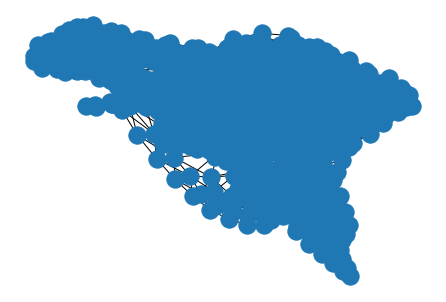

In [10]:
nx.draw(G_act, pos=nx.spring_layout(G_act))

In [40]:
nx.draw_networkx_nodes(G_act, pos=nx.spring_layout(G_act),node_size=1)

MemoryError: Unable to allocate array with shape (1139526, 1139526) and data type float64

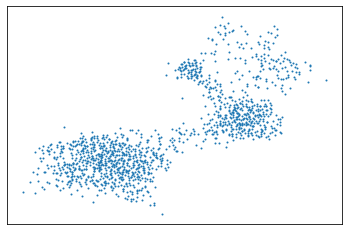

In [94]:
nx.draw_networkx_nodes(G_act, pos=nx.spring_layout(G_act),node_size=1)

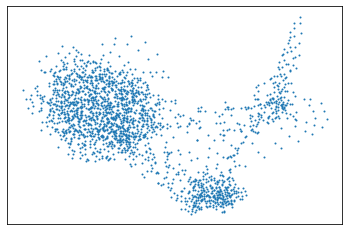

In [11]:
nx.draw_networkx_nodes(G_act, pos=nx.spring_layout(G_act),node_size=1)

In [9]:
from sklearn.manifold import TSNE

In [13]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(emb_act)

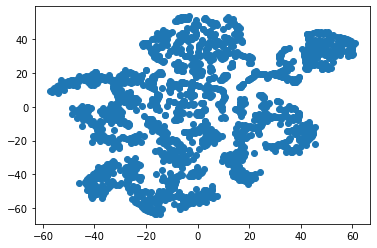

In [14]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [46]:
user_proj = {}
for u in range(len(ups)):
    up = ups[u]
    
    if up[6] == 1:
        user = up[1]
               
        proj = up[5]
        
        if user not in user_proj:
            user_proj[user] = {}
        
        if proj not in user_proj[user]:
            user_proj[user][proj] = 0
            
        user_proj[user][proj] = user_proj[user][proj] + 1

In [47]:
for user in user_proj:
    sorted_proj = sorted(user_proj[user].items(), key=operator.itemgetter(1))
    user_proj[user] = sorted_proj[0][0]

In [48]:
color_proj = {}
list_colors = list(mcolors.TABLEAU_COLORS.keys())
c = 0
for user in user_proj:
    proj = user_proj[user]
    if proj not in color_proj:
        if c == len(list_colors):
            c = 0
        color_proj[proj] = list_colors[c]
        c = c + 1

In [18]:
import matplotlib.colors as mcolors


In [57]:
list(mcolors.TABLEAU_COLORS.values())

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [41]:
user_color = []

for user in users_dict:
    user_color.append(None)

for user in users_dict:
    if user in user_proj:
        user_color[user_index_act[user]] = color_proj[user_proj[user]]
    else:
        user_color[user_index_act[user]] = 'black'

KeyError: '8M4cElrAAKDHmS+I5QTgAhCHayY='

In [54]:
user_color = []

for u in range(len(users_final)):
    user_color.append(color_proj[user_proj[users_final[u]]])

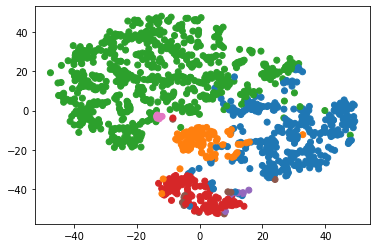

In [70]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=user_color)

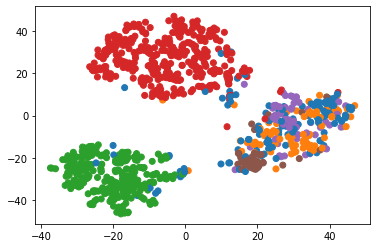

In [89]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=user_color)

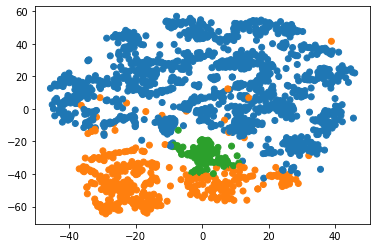

In [101]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=user_color)

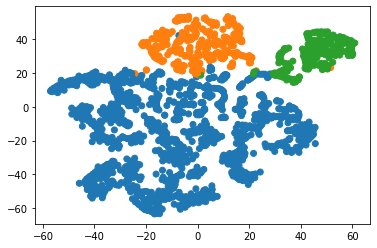

In [21]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=user_color)

In [6]:
pfile = open('user_index.pkl', 'rb')
user_index = pickle.load(pfile)
pfile.close()

In [7]:
pfile = open('node2vec_emb.pkl', 'rb')
node2vec_emb = pickle.load(pfile)
pfile.close()

In [50]:
users_final = []
users_dict = {}
j = 0
for i in range(len(ups)):
    up = ups[i]
    if up[6] == 1 and up[1] not in users_dict and up[1] in user_index:
        users_final.append(up[1])
        users_dict[up[1]] = j
        j = j + 1

In [51]:
emb_sign_final = np.zeros((len(users_final), node2vec_emb.shape[1]))

for u in range(len(users_final)):
    emb_sign_final[u] = node2vec_emb[user_index[users_final[u]]]

In [52]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(emb_sign_final)

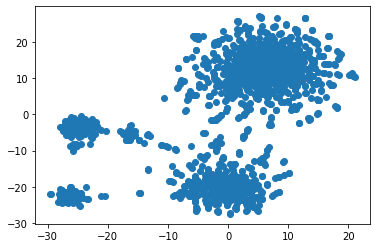

In [53]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

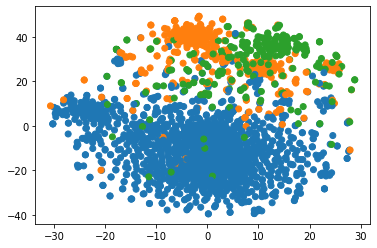

In [31]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=user_color)

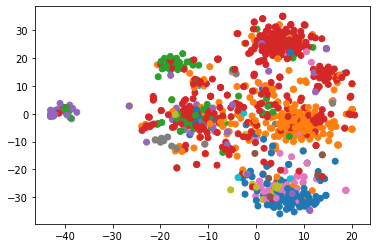

In [43]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=user_color)

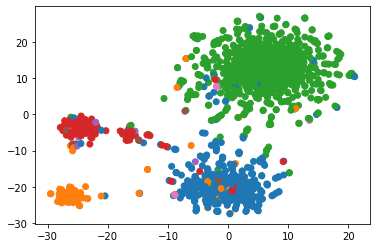

In [55]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=user_color)